# Timer

In [166]:
def print_red(text):
    print('\x1b[31m' + text + '\x1b[0m')
    
def print_yellow(text):
    print('\x1b[33m' + text + '\x1b[0m')

def print_green(text):
    print('\x1b[32m' + text + '\x1b[0m')

def print_pink(text):
    print('\x1b[35m' + text + '\x1b[0m')

def print_cyan(text):
    print('\x1b[36m' + text + '\x1b[0m')

## Ranking all annotations
Run all the possible combinations of annotations with different models and stores the winners in the variable *rounds*. There can be multiple winners.

***An annotation is a winner if it has the best value above all of the other and the best time.***

##### Example of *rounds*

|  | Ann_1 | Ann_2 | Ann_3 | Ann_4 | ... | Ann_n |
| --- | --- | --- | --- | --- | --- | --- |
| Ins_1 | 0 | 0 | 1 | 1 | ... | 0 |
| Ins_2 | 0 | 1 | 0 | 0 | ... | 1 |
| Ins_3 | 1 | 0 | 1 | 0 | ... | 0 |
| ... | ... | ... | ... | ... | ... | ... |
| Ins_m | 1 | 0 | 1 | 0 | ... | 0 |

In [167]:
import numpy as np
import os   
import subprocess 
import random
import math

def select_winners(mnts, times):
    winners = [1] * len(mnts)
    min_mnt = min(mnts)
    min_time = min(times)
    
    print('min_mnt',min_mnt, ' min_time',min_time)
    
    for i, mnt in enumerate(mnts):
        if math.isinf(mnt):
            winners[i] = 0
        else:
            if mnt == min_mnt:
                if times[i] != min_time:
                    winners[i] = 0
            else:
                winners[i] = 0

    return winners

def annotations_winners(index, models_folder, instances_folder, timeout_mzn, timeout):
    annotations = [os.path.join(models_folder, f) for f in os.listdir(models_folder) if f.endswith('.mzn')]
    instance = [os.path.join(instances_folder, f) for f in os.listdir(instances_folder) if f.endswith('.dzn')][index]
    
    mnts = [0] * len(annotations)
    times = [0] * len(annotations)
    timeout_mzn = timeout_mzn*1000
    
    for i, annotation in enumerate(annotations):
        
        if i % 9 == 0:
            print_green(f'Solving annotations from [{i}-{i+9}]')
        
        # Run the minizinc command for the current annotation and data file  
        cmd = f"minizinc --solver HiGHS --output-time {annotation} {instance} --output-time --solver-time-limit {timeout_mzn}"
        proc = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
        try: 
            # Get output from fzn
            stdout, stderr = proc.communicate(timeout=timeout) 
            stdout = stdout.decode()
            try:
                # Store value mnt (temp).
                start = stdout.find('mnt = ')+6
                end = stdout.find(';',start)
                mnt = int(stdout[start:end])
                # Store value time (temp).
                time = float(stdout.split(' ')[-2])
            except:
                mnt = float('inf')
                time = float('inf')
            # print_green(f'{annotation[10:-4]} with {instance[3:-4]} SOLVED: {mnt} in {time:.2f} seconds.')

        except subprocess.TimeoutExpired: 
            print_red(f'Error from minizinc: Stopping.')                
            mnt = float('inf')
            time = float('inf')
            if os.name == 'nt': # If the os is Windows
                subprocess.call(['taskkill', '/F', '/T', '/PID', str(proc.pid)]) # Force kill the process
            else:
                os.killpg(os.getpgid(proc.pid), signal.SIGTERM) # Kill the process group
                
        mnts[i] = mnt
        times[i] = time
    # print('mnts',mnts)
    # print('times',times)
    return select_winners(mnts,times)

n_instances = 50
rounds = np.zeros((n_instances, len([os.path.join('../models', f) for f in os.listdir('../models') if f.endswith('.mzn')])))
for i in range(0, n_instances):
    instance = random.randint(0,n_instances)
    rounds[i]=np.array(annotations_winners(instance, '../models', '../instances',5, 10))
    print_yellow(f'Finished instance: {instance}')

#r1 = np.array(annotations_winners(0, '../models', '../instances',5, 10))
#r2 = np.array(annotations_winners(5, '../models', '../instances',5, 10))

Solving annotations from [0-9]
Solving annotations from [9-18]
Solving annotations from [18-27]
Solving annotations from [27-36]
Solving annotations from [36-45]
Solving annotations from [45-54]
min_mnt inf  min_time inf
Finished instance: 0
Solving annotations from [0-9]
Solving annotations from [9-18]
Solving annotations from [18-27]
Solving annotations from [27-36]
Solving annotations from [36-45]
Solving annotations from [45-54]
min_mnt 180  min_time 0.23
Finished instance: 5
Solving annotations from [0-9]
Solving annotations from [9-18]
Solving annotations from [18-27]
Solving annotations from [27-36]
Solving annotations from [36-45]
Solving annotations from [45-54]
min_mnt 100  min_time 0.29
Finished instance: 15
Solving annotations from [0-9]
Solving annotations from [9-18]
Solving annotations from [18-27]
Solving annotations from [27-36]
Solving annotations from [36-45]
Solving annotations from [45-54]
min_mnt 110  min_time 0.56
Finished instance: 14
Solving annotations from [0

## Store and transform *rounds*

Save *rounds* to another file, sum all the rounds to get the best annotation.

In [168]:
path = '../models/rounds.txt'
with open(path, 'w', encoding='utf8') as file_object:
    file_object.write(str(rounds.tolist()))

rounds = ''
with open('../models/rounds.txt', encoding="utf8") as file_object:
        rounds = np.array(eval(file_object.read()))
        
print_pink("rounds")
print(rounds)

# sum the rounds
scores = np.sum(rounds, axis=0)
scores = scores.astype(int)

# print the scores
print_pink("\nFinal score:")
print(scores)

rounds
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 ...
 [0. 0. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]

Final score:
[14 24 28 27 28 29 27 27 26 24 20 23 26 26 30 29 30 29 26 29 27 29 28 25
 28 33 25 25 25 25 26 28 30 27 28 30 30 23 28 28 25 25 23 24 29 26 29 27
 27 30 27 28 31 31]


## Plot the scores on a bar chart.

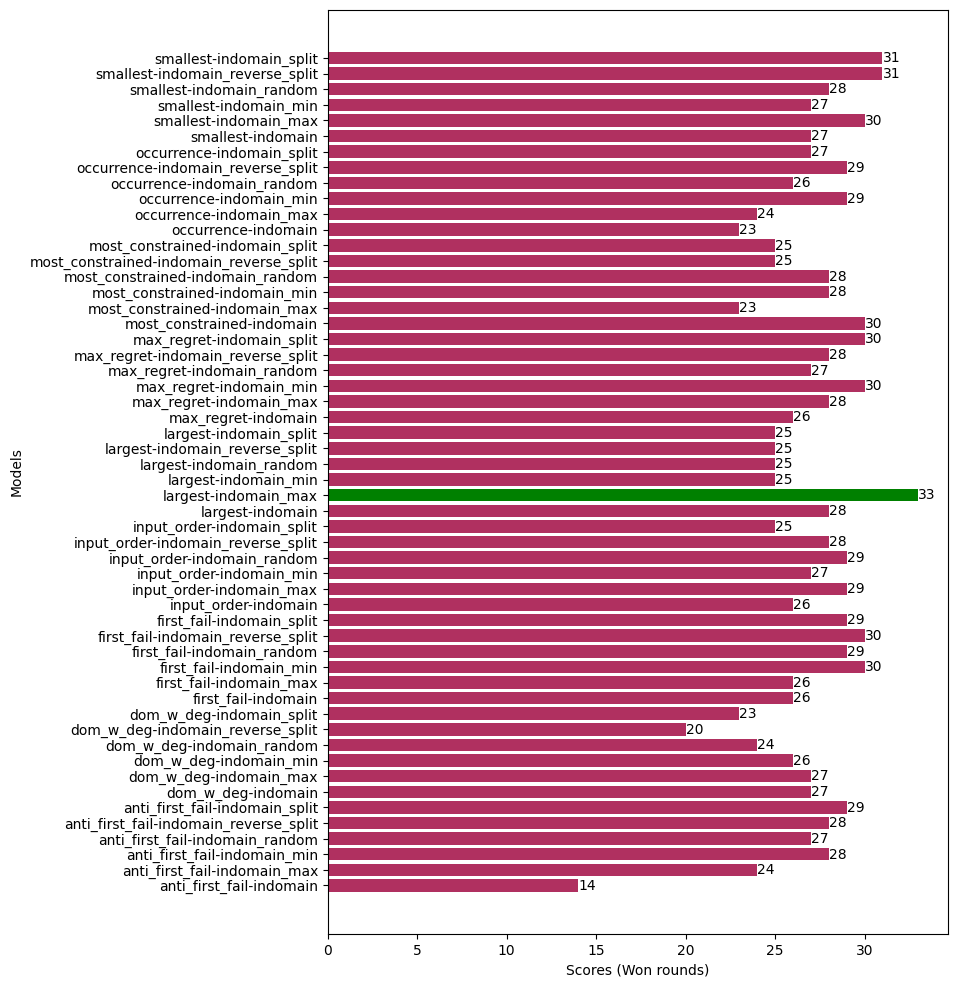

In [169]:
import matplotlib.pyplot as plt 

# Define figure size
fig, ax = plt.subplots(figsize=(8, 12))

models_folder = '../models'  
models = [os.path.join(models_folder, f) for f in os.listdir(models_folder) if f.endswith('.mzn')]
# Filter models and times
models = [model.replace("../models\\", "").replace(".mzn", "") for model in models]

# Set different color for bars with highest values
max_idx = np.max(scores)
colors = ['#b03060' if score != max_idx else 'green' for score in scores]
# Use barh function to create horizontal bar chart
ax.barh(models, scores, color=colors)

# Set x-axis label and y-axis label
ax.set_xlabel('Scores (Won rounds)')
ax.set_ylabel('Models')

# Add value labels next to each bar
for i, v in enumerate(scores):
    ax.text(v, i, str(v), color='black', ha='left', va='center')

# Show the plot
plt.show()
